<a href="https://colab.research.google.com/github/soroushmirzaei/convolutional-neural-networks-projects/blob/main/brain-tumor-mri-classification/brain-tumor-mri-classification-second-version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirements libraries
import os
import shutil
import zipfile

#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [ ]:
print("""Dataset Summary
Image dataset containing samples of meningioma (1), glioma (2), pituitary tumor (3) brain tumor types.
Cheng, Jun (2017) https://doi.org/10.6084/m9.figshare.1512427.v5

This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images from 233 patients with three kinds of brain tumor:
meningioma (708 slices), glioma (1426 slices), and pituitary tumor (930 slices).
    
This data was used in the following paper:
        
    1. Cheng, Jun, et al. "Enhanced Performance of Brain Tumor Classification via Tumor Region Augmentation
    and Partition." PloS one 10.10 (2015).
    2. Cheng, Jun, et al. "Retrieval of Brain Tumors by Adaptive Spatial Pooling and Fisher Vector
    Representation." PloS one 11.6 (2016).
""")

Dataset Summary
Image dataset containing samples of meningioma (1), glioma (2), pituitary tumor (3) brain tumor types.
Cheng, Jun (2017) https://doi.org/10.6084/m9.figshare.1512427.v5

This brain tumor dataset containing 3064 T1-weighted contrast-inhanced images from 233 patients with three kinds of brain tumor:
meningioma (708 slices), glioma (1426 slices), and pituitary tumor (930 slices).
    
This data was used in the following paper:
        
    1. Cheng, Jun, et al. "Enhanced Performance of Brain Tumor Classification via Tumor Region Augmentation
    and Partition." PloS one 10.10 (2015).
    2. Cheng, Jun, et al. "Retrieval of Brain Tumors by Adaptive Spatial Pooling and Fisher Vector
    Representation." PloS one 11.6 (2016).



In [ ]:
#make kaggle json file
kaggle_json = {
    "username":"kaggle-api-token-username",
    "key":"kaggle-api-token-key"
}
pd.Series(kaggle_json).to_json('kaggle.json')

#install kaggle libraries
!pip install -q kaggle

#setup kaggle libraries
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
#download kaggle dataset
!kaggle datasets download denizkavi1/brain-tumor


 98% 688M/700M [00:07<00:00, 121MB/s] 
100% 700M/700M [00:07<00:00, 99.4MB/s]


In [ ]:
#unzip file
def unzip(file_name, type_file = 'zip'):
    cur_dir = os.getcwd()
    file_path = os.path.join(cur_dir, f'{file_name}.{type_file}')
    file = zipfile.ZipFile(file_path)
    file.extractall(os.path.join(cur_dir, file_name))
    file.close()


In [ ]:
unzip('brain-tumor')


In [ ]:
#remove file with zero size
def remove_file_zero(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if os.path.getsize(os.path.join(root, file)) == 0:
                os.remove(os.path.join(root, file))


In [ ]:
remove_file_zero('/content/brain-tumor')


In [ ]:
#romove other file type
def remove_type(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.split('.')[-1] not in ['jpg', 'jpeg', 'bmp', 'png', 'gif']:
                os.remove(os.path.join(root, file))


In [ ]:
remove_type('/content/brain-tumor')


In [ ]:
#rename file in label num format
def rename_file(dir_path):
    for label in os.listdir(dir_path):
        num = 0
        for file in os.scandir(os.path.join(dir_path, label)):
            file_name = file.name
            ext = file_name.split('.')[1]
            num = num + 1
            os.rename(file.path, os.path.join(dir_path, label, f'{label} {num}.{ext}'))


In [ ]:
rename_file('/content/brain-tumor')


In [ ]:
#capsfold file names
def caps_file(dir_path):
    for root, dirs, files in os.walk(dir_path):
        for dir in dirs:
            os.rename(os.path.join(root,dir), os.path.join(root,dir.title()))
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            os.rename(os.path.join(root,file), os.path.join(root,file.title()))


In [ ]:
caps_file('/content/brain-tumor')


In [ ]:
#define training validation set
Height = 150
Width = 150

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.1,
                                                         rotation_range = 10)
train_data = train_gen.flow_from_directory('/content/brain-tumor',
                                           target_size = (Height, Width), batch_size = 32,
                                           color_mode = 'rgb', class_mode = 'sparse', seed = 0, subset = 'training')

valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.1)
valid_data = valid_gen.flow_from_directory('/content/brain-tumor',
                                           target_size = (Height, Width), batch_size = 32,
                                           color_mode = 'rgb', class_mode = 'sparse', seed = 0, subset = 'validation')


Found 2759 images belonging to 3 classes.
Found 305 images belonging to 3 classes.


In [ ]:
#define pretrained model
pretrained_model = keras.applications.InceptionV3(input_shape = (Height, Width, 3),
                                                  include_top = False)

for layer in pretrained_model.layers:
    layer.trainable = False

output_pre = pretrained_model.output


87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
#define custom pretrained model
out_layer = pretrained_model.get_layer('mixed8')
output_custom_pre = out_layer.output


In [ ]:
#create model function
def create_model(#convolution layer configuration
                 conv_layers_num, conv_filters, conv_kernel_size, flatten_dropout_ratio, 
                 #dense layer configuration
                 dense_layers_num, dense_units, dense_dropout_ratio,
                 #output layer configuration
                 out_dropout_ratio, out_units = train_data.num_classes,
                 #activations configuration
                 conv_activation = 'relu', dense_activation = 'relu', out_activation = 'softmax',

                 #input shape
                 inp_shape = (Height, Width, 3),

                 #compiling Configuration
                 compile_optimizer = 'adam', compile_loss ='sparse_categorical_crossentropy' ,
                 compile_metric = ['accuracy'],
                 
                 #pretrained_model configuration
                 flatten_input = None, pretrained_input = False,
                 
                 #convolution layers
                 conv_base = True, batch_norm_conv = True,
                 #flatten layer
                 flatten_layer = True, flatten_dropout_out = True,
                 #dense layers
                 dense_head = True,  batch_norm_dense = True, dropout_dense = True,
                 #output layer
                 batch_norm_out = True, dropout_out = True
                 ):

    #define input layer
    input = keras.Input(inp_shape)
    out = input

    #define convolution layers
    if conv_base:
        for i in range(conv_layers_num):
            if batch_norm_conv:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Conv2D(filters = conv_filters[i],
                                      kernel_size = conv_kernel_size[i], activation = conv_activation,
                                      kernel_initializer = keras.initializers.GlorotNormal())(out)
            out = keras.layers.MaxPool2D(pool_size = 2)(out)

    #convert two dims to one dim
    if flatten_layer:
        try:
            out = keras.layers.Flatten()(flatten_input)
        except:
            out = keras.layers.Flatten()(out)

    if flatten_dropout_out:
        out = keras.layers.Dropout(flatten_dropout_ratio)(out)

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Dense(units = dense_units[i], activation = dense_activation,
                                     kernel_initializer = keras.initializers.HeNormal())(out)
            if dropout_dense:
                out = keras.layers.Dropout(dense_dropout_ratio[i])(out)

    #define output layers
    if batch_norm_out:
        out = keras.layers.BatchNormalization()(out)
    if dropout_out:
        out = keras.layers.Dropout(out_dropout_ratio)(out)
    output = keras.layers.Dense(units = out_units, activation = out_activation)(out)

    if pretrained_input:
        input = pretrained_model.input

    model = keras.models.Model(input, output)

    #define model compile
    model.compile(optimizer = compile_optimizer,
                  loss = compile_loss,
                  metrics = compile_metric)

    return model


In [ ]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        self.model.save('/content/brain-tumor-mri-classification-model.h5')
        

In [ ]:
#create model
model = create_model(#convolution layer configuration
                     conv_layers_num = int(3), conv_filters = list([16,32,32]), conv_kernel_size = list([3,3,3]),
                     flatten_dropout_ratio = float(0.3), 
                     #dense layer configuration
                     dense_layers_num = int(2), dense_units = list([128,128]), dense_dropout_ratio = list([0.3,0.3]), 
                     #output layer configuration
                     out_dropout_ratio = float(0.3), out_units = train_data.num_classes,
                     #activations configuration
                     conv_activation = 'relu', dense_activation = 'relu', out_activation = 'softmax',
                     
                     #input shape
                     inp_shape = (Height, Width, 3),
                     
                     #compiling Configuration
                     compile_optimizer = 'adam', compile_loss = 'sparse_categorical_crossentropy' ,
                     compile_metric = ['accuracy'],
                     
                     #pretrained_model configuration
                     flatten_input = output_custom_pre, pretrained_input = True,

                     #convolution layers
                     conv_base = True, batch_norm_conv = True,
                     #flatten layer
                     flatten_layer = True, flatten_dropout_out = True,                  
                     #dense layers
                     dense_head = True,  batch_norm_dense = True, dropout_dense = True,
                     #output layer
                     batch_norm_out = True, dropout_out = True
                    )

In [ ]:
#print model summary
model.summary(120)


Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_1 (InputLayer)                  [(None, 150, 150, 3)]      0             []                                      
                                                                                                                        
 conv2d (Conv2D)                       (None, 74, 74, 32)         864           ['input_1[0][0]']                       
                                                                                                                        
 batch_normalization (BatchNormalizati  (None, 74, 74, 32)        96            ['conv2d[0][0]']                        
 on)                                                                                                                    
                 

In [ ]:
#fit model for training
model.fit(train_data, validation_data = valid_data, epochs = 100,
          callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, monitor = 'val_accuracy'),
                       keras.callbacks.CSVLogger('log.csv'), callback(),
                       keras.callbacks.ReduceLROnPlateau('val_accuracy', patience = 3, factor = 0.1)]
          )


Epoch 1/100
87/87 [==============================] - 142s 2s/step - loss: 0.6932 - accuracy: 0.7307 - val_loss: 0.3259 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 2/100
87/87 [==============================] - 137s 2s/step - loss: 0.3925 - accuracy: 0.8423 - val_loss: 0.2328 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 3/100
87/87 [==============================] - 137s 2s/step - loss: 0.3074 - accuracy: 0.8768 - val_loss: 0.2378 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 4/100
87/87 [==============================] - 136s 2s/step - loss: 0.2536 - accuracy: 0.8942 - val_loss: 0.2176 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 5/100
87/87 [==============================] - 142s 2s/step - loss: 0.2006 - accuracy: 0.9232 - val_loss: 0.2050 - val_accuracy: 0.9148 - lr: 0.0010
Epoch 6/100
87/87 [==============================] - 136s 2s/step - loss: 0.1697 - accuracy: 0.9311 - val_loss: 0.1911 - val_accuracy: 0.9410 - lr: 0.0010
Epoch 7/100
87/87 [==============================] - 136s 2s/step - lo

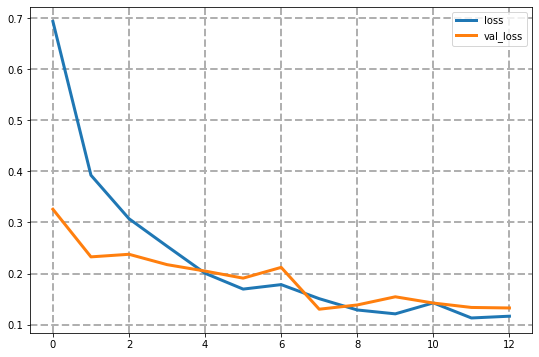

In [ ]:
#plot history and logger
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.show()


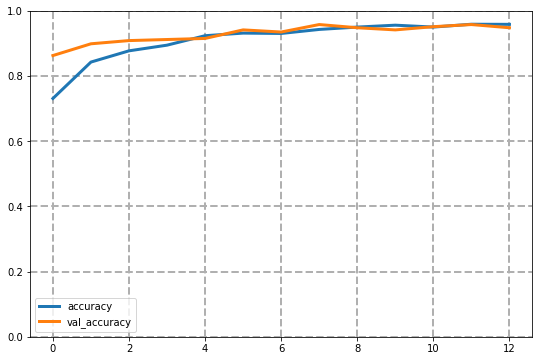

In [ ]:
#plot history and logger
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.ylim(0,1)
plt.show()


In [ ]:
#model evaluation
train_set_eval = model.evaluate(train_data, verbose = 0)
valid_set_eval = model.evaluate(valid_data, verbose = 0)

print(f'Training Set Evaluation:\n\tLoss: {round(train_set_eval[0],4)}\tAccuracy: {100*round(train_set_eval[1],4)}%')
print(f'Validation Set Evaluation:\n\tLoss: {round(valid_set_eval[0],4)}\tAccuracy: {100*round(valid_set_eval[1],4)}%')


Training Set Evaluation:
	Loss: 0.0325	Accuracy: 99.17%
Validation Set Evaluation:
	Loss: 0.1304	Accuracy: 95.7%


In [ ]:
#make list of images for random prediction
def image_file(dir_path):
    image_list = list()
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            image_list.append(os.path.join(root, file))
    return image_list


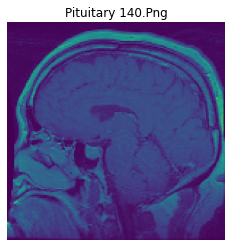

In [ ]:
#draw random image
img = np.random.choice(image_file('/content/brain-tumor'))
image = img
img = keras.preprocessing.image.load_img(img, target_size = (Height, Width),
                                         color_mode = 'rgb')
img = keras.preprocessing.image.img_to_array(img)

img = img/255
plt.axis('off')
plt.imshow(img)
plt.title(image.split('/')[-1])
plt.show()


In [ ]:
#prediction for random image
img = np.expand_dims(img, 0)
pd.DataFrame(model.predict(img), columns = train_data.class_indices)


,Glioma,Meningioma,Pituitary
0,4.052495e-09,4.391887e-07,1.0


In [ ]:
#save model
model.save('/content/brain-tumor-mri-classification-model.h5')
